# Commuting 2Q gates transpiler pass

In [1]:
from qiskit import QuantumCircuit, transpile
from qiskit.opflow import PauliSumOp
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.transpiler import Layout, CouplingMap, PassManager
from qiskit.transpiler.passes import FullAncillaAllocation
from qiskit.transpiler.passes import EnlargeWithAncilla
from qiskit.transpiler.passes import ApplyLayout
from qiskit.transpiler.passes import SetLayout
from qiskit.transpiler.passes.routing.commuting_2q_gate_routing import (
    SwapStrategy,
    FindCommutingPauliEvolutions,
    Commuting2qGateRouter,
)

## Swap strategies introduction

* Certain circuits, such as those of QAOA, are made of commuting two-qubit gates that create a dense network. 
* Generic transpiler passes are often sub-optimal as they fail to properly exploit the commutative nature of the two-qubit gates.
* We can **exploit two-qubit gate commutativity** to reduce the CX gate count when transpiling to hardware.

**Terra PR**: https://github.com/Qiskit/qiskit-terra/pull/7813

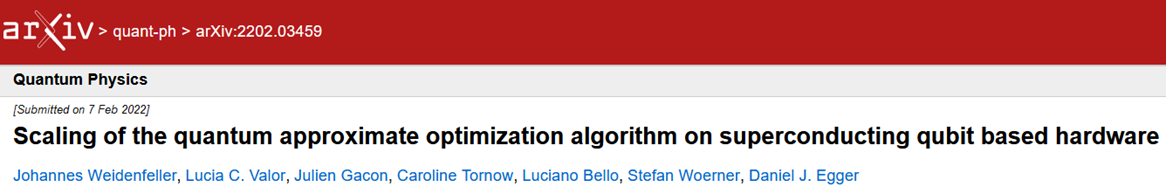

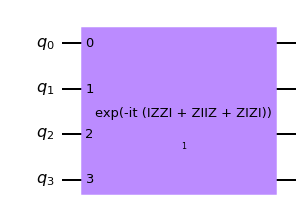

In [18]:
# Define the circuit on logical qubits
op = PauliSumOp.from_list([("IZZI", 1), ("ZIIZ", 2), ("ZIZI", 3)])
circ = QuantumCircuit(4)
circ.append(PauliEvolutionGate(op, 1), range(4))
circ.draw("mpl")

In the gate above, all two-qubit gates commute.

* The `FindCommutingPauliEvolutions` transpiler pass is designed specifically to identify Pauli evolution gates made of commuting two-qubit gates. 
* Other transpiler passes can be developed for the general case, see e.g., https://github.com/Qiskit/qiskit-terra/pull/8034 i.e. PR `Commuting2qGateGrouper pass`.

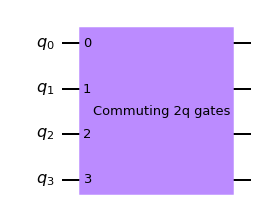

In [19]:
PassManager([FindCommutingPauliEvolutions()]).run(circ).draw("mpl")

We will use a carefully designed **swap strategy** to transpile the circuit to a given coupling map. In this example the coupling map is

```
0 -- 1 -- 2
     |
     3
     |
     4
```

A **Swap Strategy** is a set of predefined layers of swaps. For example

In [24]:
swap_layers = (
    ((1, 3), ),         # Layer 1: swap qubits 1 & 3
    ((0, 1), (3, 4)),   # Layer 2: simultaneouosly swap qubits 0 & 1 and 3 & 4
    ((1, 3), )          # Layer 3: swap qubits 1 & 3
)

This swap strategy achieves full connectivity on the coupling map above.

In [25]:
cmap = CouplingMap(couplinglist=[(0, 1), (1, 2), (1, 3), (3, 4)])
swap_strat = SwapStrategy(cmap, swap_layers)
print(f"Missing connectivity: {swap_strat.missing_couplings}")

Missing connectivity: set()


## Transpiling with swap strategies

In [26]:
backend_cmap = CouplingMap(couplinglist=[(0, 1), (1, 2), (1, 3), (3, 4)])

In [28]:
def make_passmanager(cmap, swap_strat, initial_layout):
    """Creates the passes needed."""
    return PassManager(
    [
        FindCommutingPauliEvolutions(),
        Commuting2qGateRouter(swap_strat),
        SetLayout(initial_layout),
        FullAncillaAllocation(backend_cmap),
        EnlargeWithAncilla(),
        ApplyLayout(),
    ]
)

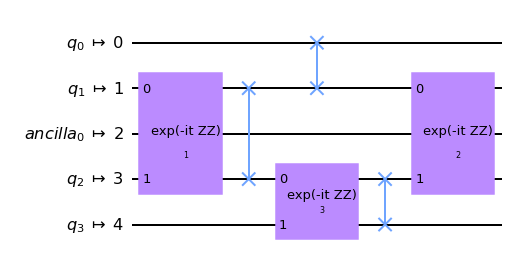

In [29]:
# Define the swap strategy on qubits before the initial_layout is applied.
swap_cmap = CouplingMap(couplinglist=[(0, 1), (1, 2), (2, 3)])
swap_strat = SwapStrategy(swap_cmap, swap_layers=[[(1, 2)], [(0, 1), (2, 3)]])
# Chose qubits 0, 1, 3, and 4 from the backend coupling map shown above.
backend_cmap = CouplingMap(couplinglist=[(0, 1), (1, 2), (1, 3), (3, 4)])
initial_layout = Layout.from_intlist([0, 1, 3, 4], *circ.qregs)

pm = make_passmanager(backend_cmap, swap_strat, initial_layout)

# Insert swap gates, map to initial_layout and finally enlarge with ancilla.
pm.run(circ).draw("mpl")

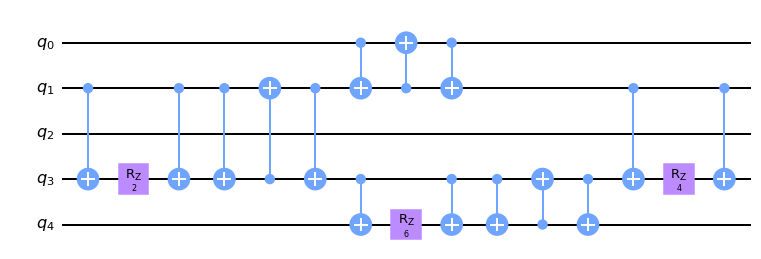

In [30]:
pm.run(circ).decompose().decompose().draw("mpl")

## Example on a fully-connected problem

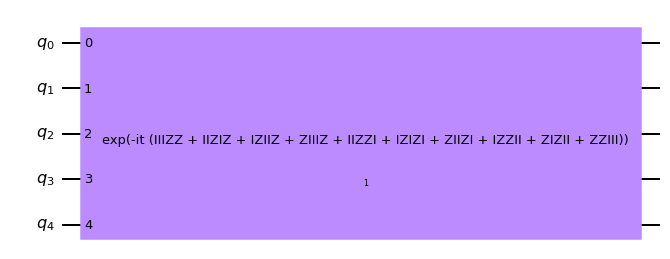

In [31]:
op = PauliSumOp.from_list(
    [
        ("IIIZZ", 1), ("IIZIZ", 1), ("IZIIZ", 1), ("ZIIIZ", 2), 
        ("IIZZI", 3), ("IZIZI", 3), ("ZIIZI", 4),
        ("IZZII", 1), ("ZIZII", 2),
        ("ZZIII", 2),
    ]
)
circ = QuantumCircuit(5)
circ.append(PauliEvolutionGate(op, 1), range(5))
circ.draw("mpl")

In [32]:
swap_cmap = CouplingMap(couplinglist=[(0, 1), (1, 2), (1, 3), (3, 4)])

swap_strat = SwapStrategy(swap_cmap, swap_layers=[[(1, 3)], [(0, 1), (3, 4)], [(1, 3)]])
swap_strat.missing_couplings

set()

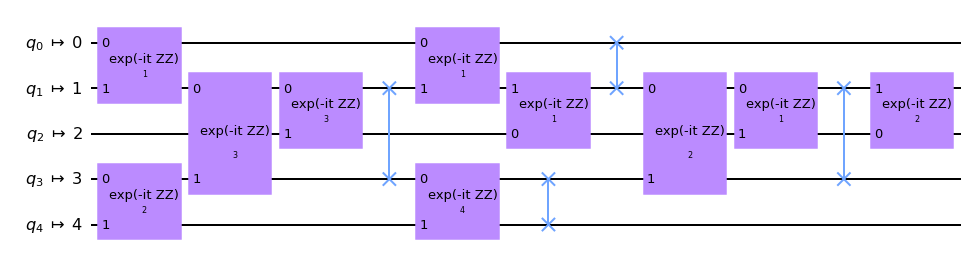

In [33]:
initial_layout = Layout.from_intlist([0, 1, 2, 3, 4], *circ.qregs)
pm = make_passmanager(backend_cmap, swap_strat, initial_layout)

swapped_circ = pm.run(circ)
swapped_circ.draw("mpl")

This circuit is compatible with the layout of the coupling map. We can further transpile this circuit to get ride of double CNOT gates.

Number of CNOTs: 26
Number of X and SX: 0.
Depth 27.


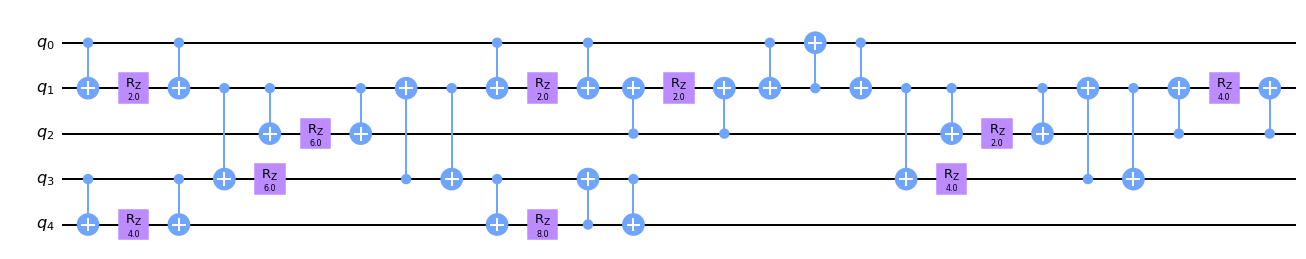

In [34]:
tswapped = transpile(swapped_circ, basis_gates=["rz", "cx"], optimization_level=2)
n_cx = tswapped.count_ops()["cx"]
n_xsx = tswapped.count_ops().get("sx", 0) + tswapped.count_ops().get("x", 0)
print(f"Number of CNOTs: {n_cx}\nNumber of X and SX: {n_xsx}.")
print(f"Depth {tswapped.depth()}.")
tswapped.draw("mpl", fold=False)

Number of CNOTs: 36
Number of X and SX: 28.
Depth 77.


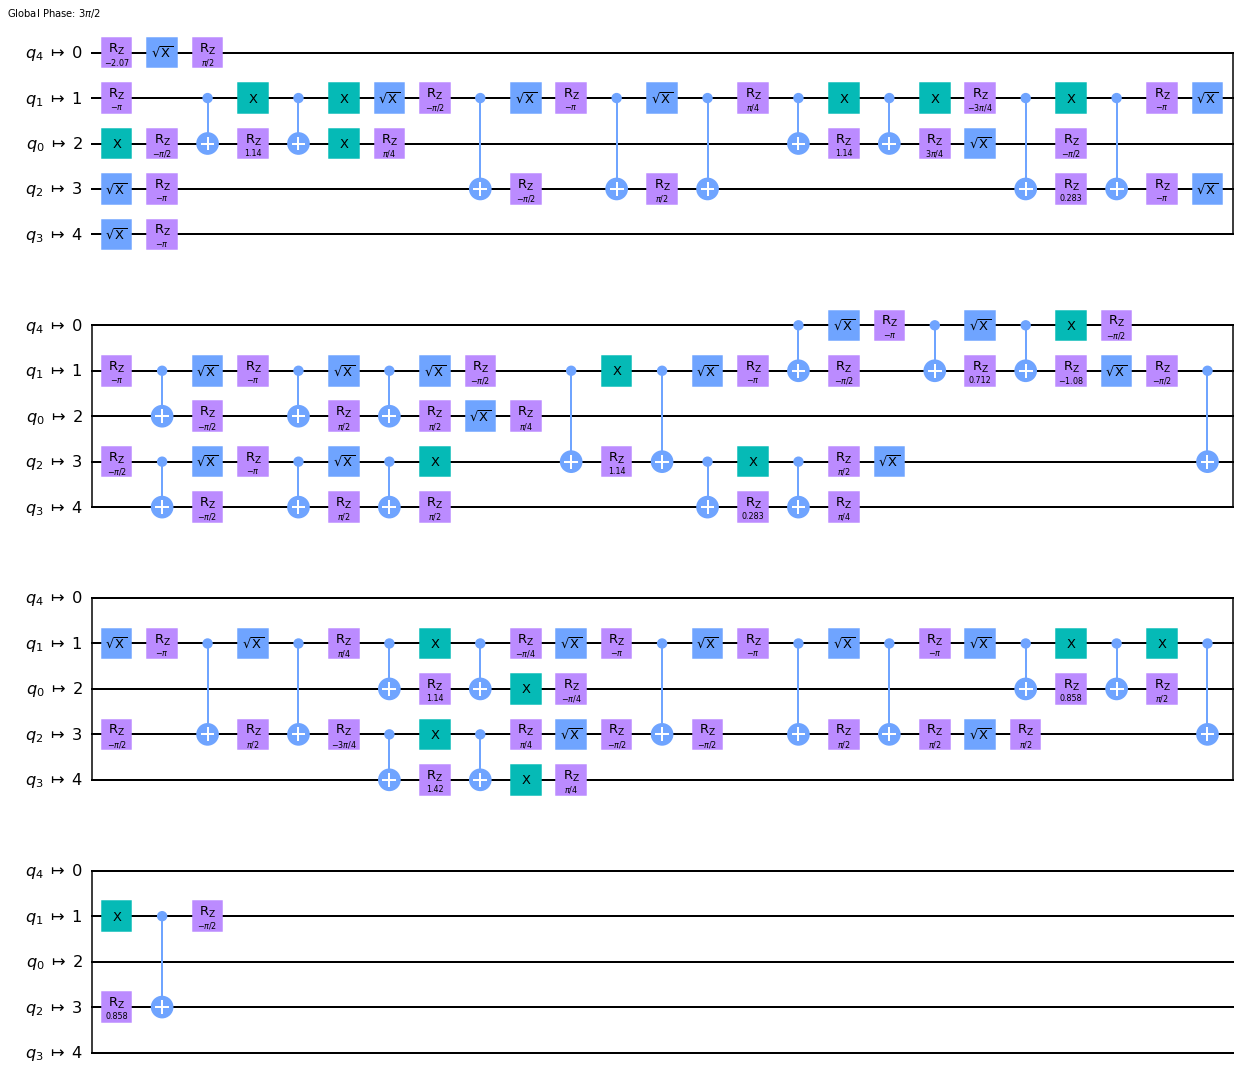

In [37]:
opt3_circ = transpile(circ, basis_gates=["rz", "cx", "sx", "x"], optimization_level=3, coupling_map=backend_cmap)
n_cx = opt3_circ.count_ops()["cx"]
n_xsx = opt3_circ.count_ops().get("sx", 0) + tswapped.count_ops().get("x", 0)
print(f"Number of CNOTs: {n_cx}\nNumber of X and SX: {n_xsx}.")
print(f"Depth {opt3_circ.depth()}.")
opt3_circ.draw("mpl")

## Summary

* Exploting gate commutativity reduces circuit depth and gate count.
* Transpiler pass is much faster than e.g. SaberSwap.
* Details in **arXiv:2202.03459**, *Scaling of the quantum approximate optimization algorithm on superconducting qubit based hardware* 